# OpenPrescribing.net API

The OpenPrescribing.net website, which makes [GP presentation level prescription data](http://digital.nhs.uk/searchcatalogue?productid=21636) available via an API, also has a service that details BNF (British National Formulary) codes for items associated with BNF sections, along with monthly summaries of spend by CCG and GP Practice relative to BNC codes. For example, in the *Prescribing for Diabetes* data, these are broken down as:

 - Drugs used in diabetes ( BNF 6.1)
 - Insulins (BNF 6.1.1)
 - Antidiabetic drugs (BNF 6.1.2)
 - Diagnostic monitor (BNF 6.1.6)
 
The OpenPrescribing data allows us to generate more detailed reports thank simple summary data about the monthly prescribing behaviour for a CCG as a whole, or within the practices associated with a CCG. For example, we can look at spend relating to particular BNF sections, or spend on particular chemicals within those sections.

### OpenPrescribing Reports

This section covers report generating from OpenPrescribing.net

See also BNF - http://www.evidence.nhs.uk/formulary/bnf/current eg http://www.evidence.nhs.uk/formulary/bnf/current/6-endocrine-system/61-drugs-used-in-diabetes/611-insulins

In [40]:
%matplotlib inline
#Support embedded charts

#The pandas library is provides support for managing and analysing tabular data
import pandas as pd

In [41]:
#For reporting purposes, it can be handy to associate dates with the corresponding financial year
def getFinancialYear(dt):
    year = dt.year
    if dt.month<4 or (dt.month==4 and dt.day<6): year -= 1
    return year

In [42]:
#Test for getFinancialYear()
#import datetime
#getFinancialYear(datetime.datetime.strptime('6Apr2013', '%d%b%Y'))

In [43]:
#The openprescribing API throws a 403 on requests from pandas direct
#Calling using requests works fine though....
import requests
from StringIO import StringIO

def proxy(url):
    return StringIO(requests.get(url).content)


def op_spending_by_practice(ccg, bnfcode):
    url='https://openprescribing.net/api/1.0/spending_by_practice/?code={bnfcode}&org={ccg}&format=csv'.format(ccg=ccg,bnfcode=bnfcode)
    try:
        df = pd.read_csv(proxy(url), parse_dates=['date'])
    except: return None
    df['bnf']=bnfcode
    df['fyear']=df['date'].apply(getFinancialYear)
    return df

gpspend=op_spending_by_practice('10L', '0601')
gpspend.head()

,actual_cost,ccg,date,items,quantity,row_id,row_name,setting,bnf,fyear
0,6126.95,10L,2010-08-01,401,24385,J84003,VENTNOR MEDICAL CENTRE,4,0601,2010
1,9333.57,10L,2010-08-01,653,33909,J84004,EAST COWES MEDICAL CENTRE,4,0601,2010
2,11975.76,10L,2010-08-01,731,43936,J84005,ESPLANADE SURGERY,4,0601,2010
3,8514.27,10L,2010-08-01,531,34391,J84007,ST.HELENS MEDICAL CENTRE,4,0601,2010
4,5120.05,10L,2010-08-01,325,21800,J84008,ARGYLL HOUSE,4,0601,2010


In [44]:
def op_spending_by_ccg(ccg, bnfcode):
    url='https://openprescribing.net/api/1.0/spending_by_ccg/?code={bnfcode}&org={ccg}&format=csv'.format(ccg=ccg,bnfcode=bnfcode)
    try:
        df = pd.read_csv(proxy(url), parse_dates=['date'])
    except: return None
    df['bnf']=bnfcode
    df['fyear']=df['date'].apply(getFinancialYear)
    return df

ccgspend=op_spending_by_ccg('10L', '0601')
ccgspend.head()

,actual_cost,date,items,quantity,row_id,row_name,bnf,fyear
0,169832.60,2013-04-01,10977,679174,10L,NHS ISLE OF WIGHT CCG,0601,2012
1,174846.30,2013-05-01,11336,702973,10L,NHS ISLE OF WIGHT CCG,0601,2013
2,165940.25,2013-06-01,10418,652119,10L,NHS ISLE OF WIGHT CCG,0601,2013
3,174288.31,2013-07-01,11070,687111,10L,NHS ISLE OF WIGHT CCG,0601,2013
4,180006.92,2013-08-01,11308,708590,10L,NHS ISLE OF WIGHT CCG,0601,2013


In [45]:
ccgspend.groupby(ccgspend['date'].apply(getFinancialYear))['actual_cost'].sum()

date
2012     169832.60
2013    2094594.94
2014    2283035.52
2015    2424169.27
2016     411103.82
Name: actual_cost, dtype: float64

In [46]:
ccgspend.groupby(ccgspend['date'].apply(getFinancialYear))['items'].sum()

date
2012     10977
2013    131427
2014    136301
2015    139250
2016     23309
Name: items, dtype: int64

In [47]:
ccgav=ccgspend.groupby(ccgspend['date'].apply(getFinancialYear))[['items','actual_cost']].sum()
ccgav['av']=ccgav['actual_cost']/ccgav['items']
ccgav

,items,actual_cost,av
date,,,
2012,10977,169832.60,15.471677
2013,131427,2094594.94,15.937326
2014,136301,2283035.52,16.749954
2015,139250,2424169.27,17.408756
2016,23309,411103.82,17.637128


In [48]:
#http://stackoverflow.com/a/27844045/454773
gpspend[gpspend['fyear']>2013].groupby([gpspend['fyear'],'row_id','row_name'])['actual_cost'].sum().groupby(level=0, group_keys=False).nlargest(5)

fyear  row_id  row_name                   
2014   J84013  SANDOWN HEALTH CENTRE          231331.49
       J84015  COWES MEDICAL CENTRE           229969.68
       J84019  WEST WIGHT MEDICAL PRACTICE    205021.95
       J84014  THE DOWER HOUSE                179323.56
       J84005  ESPLANADE SURGERY              174274.28
2015   J84013  SANDOWN HEALTH CENTRE          257814.23
       J84015  COWES MEDICAL CENTRE           238539.81
       J84019  WEST WIGHT MEDICAL PRACTICE    224629.19
       J84014  THE DOWER HOUSE                187933.05
       J84005  ESPLANADE SURGERY              183316.24
2016   J84013  SANDOWN HEALTH CENTRE           45256.51
       J84005  ESPLANADE SURGERY               37653.73
       J84019  WEST WIGHT MEDICAL PRACTICE     36200.82
       J84015  COWES MEDICAL CENTRE            35100.96
       J84014  THE DOWER HOUSE                 31382.03
Name: actual_cost, dtype: float64

In [49]:
gpspend.groupby([gpspend['date'].apply(getFinancialYear),'row_id','row_name'])['items'].sum().groupby(level=0, group_keys=False).nlargest(5)

date  row_id  row_name                   
2010  J84013  SANDOWN HEALTH CENTRE           8531
      J84010  SHANKLIN MEDICAL CENTRE         7015
      J84019  WEST WIGHT MEDICAL PRACTICE     7010
      J84014  THE DOWER HOUSE                 6866
      J84005  ESPLANADE SURGERY               6831
2011  J84013  SANDOWN HEALTH CENTRE          11766
      J84014  THE DOWER HOUSE                 9856
      J84019  WEST WIGHT MEDICAL PRACTICE     9584
      J84005  ESPLANADE SURGERY               9173
      J84004  EAST COWES MEDICAL CENTRE       9029
2012  J84013  SANDOWN HEALTH CENTRE          12691
      J84019  WEST WIGHT MEDICAL PRACTICE    10488
      J84014  THE DOWER HOUSE                10379
      J84010  SHANKLIN MEDICAL CENTRE         9931
      J84004  EAST COWES MEDICAL CENTRE       9781
2013  J84013  SANDOWN HEALTH CENTRE          13601
      J84014  THE DOWER HOUSE                11249
      J84019  WEST WIGHT MEDICAL PRACTICE    11038
      J84004  EAST COWES MEDICAL CENTRE 

In [50]:
tmp=gpspend.groupby([gpspend['date'].apply(getFinancialYear),'row_id','row_name'])[['items','actual_cost']].sum()
tmp['av']=tmp['actual_cost']/tmp['items']
tmp

items  actual_cost         av
date row_id row_name                                                   
2010 J84003 VENTNOR MEDICAL CENTRE         3713     57089.46  15.375562
     J84004 EAST COWES MEDICAL CENTRE      6280     89793.35  14.298304
     J84005 ESPLANADE SURGERY              6831    115987.24  16.979540
     J84007 ST.HELENS MEDICAL CENTRE       4838     78744.52  16.276255
     J84008 ARGYLL HOUSE                   3065     49527.09  16.158920
     J84010 SHANKLIN MEDICAL CENTRE        7015     89201.69  12.715850
     J84011 CARISBROOKE HEALTH CENTRE      5535     91296.47  16.494394
     J84012 TOWER HOUSE SURGERY            5889     87913.88  14.928490
     J84013 SANDOWN HEALTH CENTRE          8531    127043.58  14.891992
     J84014 THE DOWER HOUSE                6866    113867.55  16.584263
     J84015 COWES MEDICAL CENTRE           5543    144135.43  26.003145
     J84016 SOUTH WIGHT MEDICAL PRACTICE   3922     70758.16  18.041346
     J84017 MEDINA HEALTHCARE              5830     81282.25  13.942067
     J84018 GROVE HOUSE SURGERY            2247     41383.92  18.417410
     J84019 WEST WIGHT MEDICAL PRACTICE    7010    110810.46  15.807484
     J84020 BEECH GROVE SURGERY            3099     45556.75  14.700468
     J84602 GARFIELD ROAD SURGERY          1987     34799.02  17.513347
     Y00438 INTERMEDIATE CARE SERVICES       43       459.63  10.689070
     Y00588 ISLAND HEALTH LINE               11       314.73  28.611818
     Y02758 BEACON HEALTH                    87      1413.65  16.248851
2011 J84003 VENTNOR MEDICAL CENTRE         4801     77590.06  16.161229
     J84004 EAST COWES MEDICAL CENTRE      9029    123537.26  13.682275
     J84005 ESPLANADE SURGERY              9173    154853.60  16.881456
     J84007 ST.HELENS MEDICAL CENTRE       7013    111206.48  15.857191
     J84008 ARGYLL HOUSE                   4293     68721.75  16.007862
     J84010 SHANKLIN MEDICAL CENTRE        9018    117289.65  13.006171
     J84011 CARISBROOKE HEALTH CENTRE      7452    128408.13  17.231365
     J84012 TOWER HOUSE SURGERY            8273    126862.07  15.334470
     J84013 SANDOWN HEALTH CENTRE         11766    184359.68  15.668849
     J84014 THE DOWER HOUSE                9856    161315.37  16.367225
...                                         ...          ...        ...
2015 J84014 THE DOWER HOUSE               11824    187933.05  15.894202
     J84015 COWES MEDICAL CENTRE           9067    238539.81  26.308571
     J84016 SOUTH WIGHT MEDICAL PRACTICE   6100    126868.97  20.798192
     J84017 MEDINA HEALTHCARE              7919    139336.39  17.595200
     J84018 GROVE HOUSE SURGERY            3735     73849.63  19.772324
     J84019 WEST WIGHT MEDICAL PRACTICE   12767    224629.19  17.594516
     J84020 BEECH GROVE SURGERY            4369     78578.97  17.985573
     J84602 GARFIELD ROAD SURGERY          2879     42104.34  14.624641
     Y00438 INTERMEDIATE CARE SERVICES      113      1305.52  11.553274
     Y02758 BEACON HEALTH                   144      2025.32  14.064722
2016 J84003 VENTNOR MEDICAL CENTRE          872     12347.17  14.159599
     J84004 EAST COWES MEDICAL CENTRE      1831     25593.42  13.977837
     J84005 ESPLANADE SURGERY              1501     37653.73  25.085763
     J84007 ST.HELENS MEDICAL CENTRE       1365     20209.84  14.805744
     J84008 ARGYLL HOUSE                    993     16055.50  16.168681
     J84010 SHANKLIN MEDICAL CENTRE        1827     28012.90  15.332731
     J84011 CARISBROOKE HEALTH CENTRE      1534     26505.66  17.278787
     J84012 TOWER HOUSE SURGERY            1682     25581.69  15.209090
     J84013 SANDOWN HEALTH CENTRE          2424     45256.51  18.670177
     J84014 THE DOWER HOUSE                2024     31382.03  15.504956
     J84015 COWES MEDICAL CENTRE           1330     35100.96  26.391699
     J84016 SOUTH WIGHT MEDICAL PRACTICE   1085     21686.69  19.987733
     J84017 MEDINA HEALTHCARE              1292     22863.09  17.695890
     J8401

In [51]:
def op_drugs_used_in(bnf,insection=True):
    url='https://openprescribing.net/api/1.0/bnf_code/?q={bnf}&format=csv'.format(bnf=bnf)
    df =pd.read_csv(proxy(url))
    df['bnf']=bnf
    df=df[df['id'].str.startswith(bnf)]
    if insection and 'section' in df:
        df=df[pd.notnull(df['section'])]
    return df

df=op_drugs_used_in('060101')
df

,id,is_generic,name,section,type,bnf
0,0601011I0,NaN,Acid Insulin Injection,6.1: Drugs Used In Diabetes,chemical,060101
1,0601012W0,NaN,Biphasic Insulin Aspart,6.1: Drugs Used In Diabetes,chemical,060101
2,0601012C0,NaN,Biphasic Insulin Injection,6.1: Drugs Used In Diabetes,chemical,060101
3,0601012F0,NaN,Biphasic Insulin Lispro,6.1: Drugs Used In Diabetes,chemical,060101
4,0601012D0,NaN,Biphasic Isophane Insulin,6.1: Drugs Used In Diabetes,chemical,060101
5,0601012AA,NaN,Ins Degludec/Liraglutide,6.1: Drugs Used In Diabetes,chemical,060101
6,0601011A0,NaN,Insulin Aspart,6.1: Drugs Used In Diabetes,chemical,060101
7,0601012Z0,NaN,Insulin Degludec,6.1: Drugs Used In Diabetes,chemical,060101
8,0601012X0,NaN,Insulin Detemir,6.1: Drugs Used In Diabetes,chemical,060101
9,0601012V0,NaN,Insulin Glargine,6.1: Drugs Used In Diabetes,chemical,060101


In [52]:
df=op_drugs_used_in('6.1')
df

,id,is_generic,name,type,bnf
0,6.1,NaN,Drugs Used In Diabetes,BNF section,6.1
1,6.1.1,NaN,Insulin,BNF paragraph,6.1
2,6.1.2,NaN,Antidiabetic Drugs,BNF paragraph,6.1
3,6.1.4,NaN,Treatment Of Hypoglycaemia,BNF paragraph,6.1
4,6.1.5,NaN,Diabetic Nephropathy & Neuropathy,BNF paragraph,6.1
5,6.1.6,NaN,Diabetic Diagnostic & Monitoring Agents,BNF paragraph,6.1


In [53]:
op_drugs_used_in('060106')

,id,is_generic,name,section,type,bnf
0,0601060D0,NaN,Glucose Blood Testing Reagents,6.1: Drugs Used In Diabetes,chemical,060106
1,0601060W0,NaN,Ketone Blood Testing Reagents,6.1: Drugs Used In Diabetes,chemical,060106
2,060106000,NaN,Other Screening & Monitoring Agent Preps,6.1: Drugs Used In Diabetes,chemical,060106
3,0601060U0,NaN,Urine Testing Reagents,6.1: Drugs Used In Diabetes,chemical,060106


In [54]:
df=pd.DataFrame()
for index, row in op_drugs_used_in('060106').iterrows():
    print(row['id'])
    df2=op_spending_by_practice('10L', row['id'])
    if df2 is not None:
        df=pd.concat([df,df2])


0601060D0
0601060W0
060106000
0601060U0


In [55]:
df=pd.merge(df,op_drugs_used_in('060106'),left_on='bnf',right_on='id')

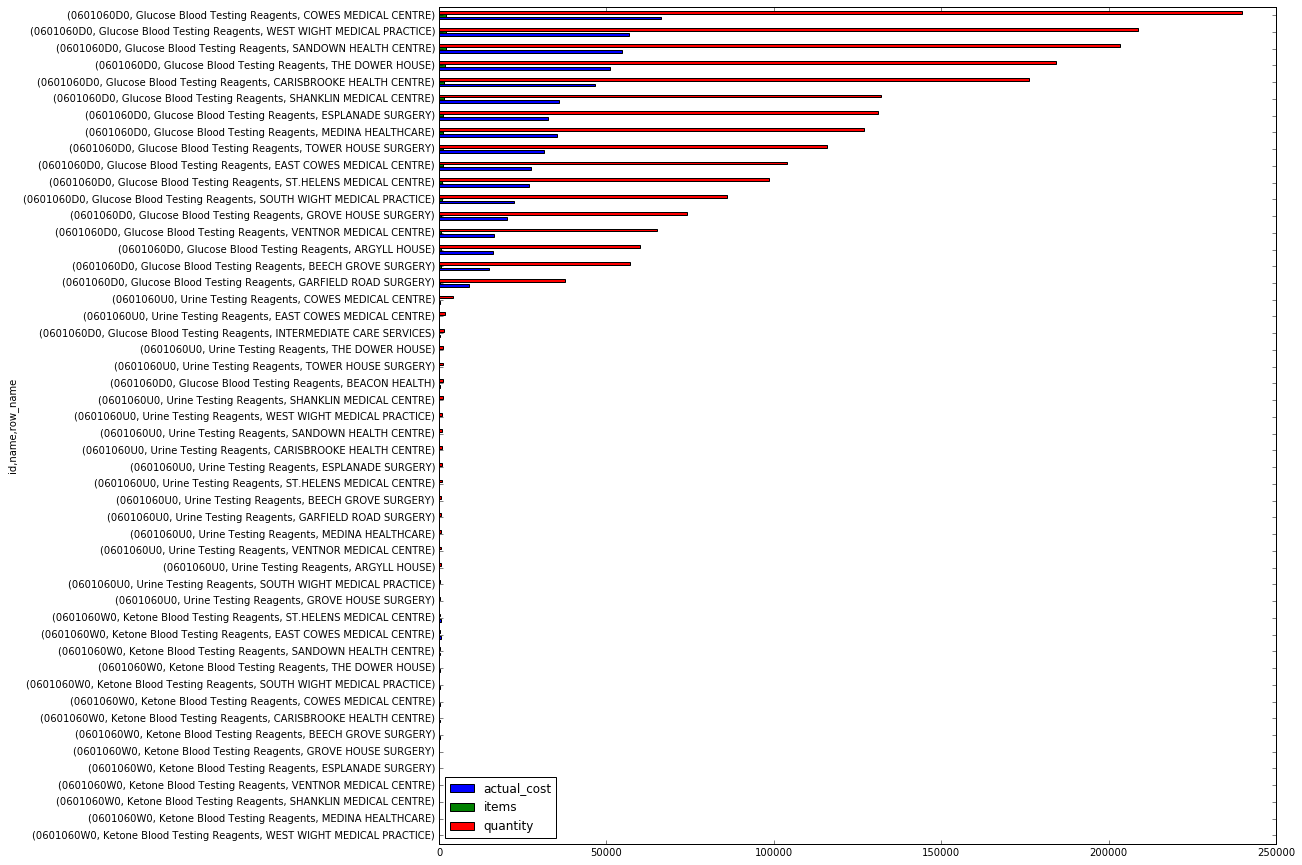

In [56]:
df[df['fyear']==2015].groupby(['id','name','row_name'])['actual_cost','items','quantity'].sum().sort_values(['quantity'],ascending=True).plot(kind='barh',figsize=(15,15))

In [57]:
ddf=df[df['fyear']==2015].groupby(['id','name','row_name'])['actual_cost','items','quantity'].sum().sort_values(['quantity'],ascending=True)
ddf

actual_cost  \
id        name                           row_name                                    
0601060W0 Ketone Blood Testing Reagents  WEST WIGHT MEDICAL PRACTICE         19.58   
                                         MEDINA HEALTHCARE                   39.12   
                                         SHANKLIN MEDICAL CENTRE             38.50   
                                         VENTNOR MEDICAL CENTRE              39.16   
                                         ESPLANADE SURGERY                   58.74   
                                         GROVE HOUSE SURGERY                 78.28   
                                         BEECH GROVE SURGERY                156.36   
                                         CARISBROOKE HEALTH CENTRE          155.79   
                                         COWES MEDICAL CENTRE               156.37   
                                         SOUTH WIGHT MEDICAL PRACTICE       213.97   
                                         THE DOWER HOUSE                    234.39   
                                         SANDOWN HEALTH CENTRE              350.79   
                                         EAST COWES MEDICAL CENTRE          449.26   
                                         ST.HELENS MEDICAL CENTRE           467.47   
0601060U0 Urine Testing Reagents         GROVE HOUSE SURGERY                 16.13   
                                         SOUTH WIGHT MEDICAL PRACTICE        19.52   
                                         ARGYLL HOUSE                        24.79   
                                         VENTNOR MEDICAL CENTRE              27.92   
                                         MEDINA HEALTHCARE                   27.61   
                                         GARFIELD ROAD SURGERY               29.52   
                                         BEECH GROVE SURGERY                 36.76   
                                         ST.HELENS MEDICAL CENTRE            44.93   
                                         ESPLANADE SURGERY                   46.40   
                                         CARISBROOKE HEALTH CENTRE           45.91   
                                         SANDOWN HEALTH CENTRE               48.25   
                                         WEST WIGHT MEDICAL PRACTICE         52.04   
                                         SHANKLIN MEDICAL CENTRE             58.35   
0601060D0 Glucose Blood Testing Reagents BEACON HEALTH                      314.22   
0601060U0 Urine Testing Reagents         TOWER HOUSE SURGERY                 65.31   
                                         THE DOWER HOUSE                     73.07   
0601060D0 Glucose Blood Testing Reagents INTERMEDIATE CARE SERVICES         381.14   
0601060U0 Urine Testing Reagents         EAST COWES MEDICAL CENTRE           93.94   
                                         COWES MEDICAL CENTRE               228.07   
0601060D0 Glucose Blood Testing Reagents GARFIELD ROAD SURGERY             8805.39   
                                         BEECH GROVE SURGERY              14986.67   
                                         ARGYLL HOUSE                     16000.98   
                                         VENTNOR MEDICAL CENTRE           16333.21   
                                         GROVE HOUSE SURGERY              20194.06   
                                         SOUTH WIGHT MEDICAL PRACTICE     22399.14   
                                         ST.HELENS MEDICAL CENTRE         26948.36   
                                         EAST COWES MEDICAL CENTRE        27387.04   
                                         TOWER HOUSE SURGERY              31208.80   
                                         MEDINA HEALTHCARE                35148.30   
                                         ESPLANADE SURGERY                32484.00   
                                         SHANKLIN MEDICAL CENTRE          35843.40   
                             

In [58]:
ddf['cost_per_item']=ddf['actual_cost']/ddf['items']
ddf['quantity_per_item']=ddf['quantity']/ddf['items']
ddf['cost_per_quantity']=ddf['actual_cost']/ddf['quantity']
ddf.sort_values('cost_per_quantity',ascending=False)

actual_cost  \
id        name                           row_name                                    
0601060W0 Ketone Blood Testing Reagents  WEST WIGHT MEDICAL PRACTICE         19.58   
                                         VENTNOR MEDICAL CENTRE              39.16   
                                         ESPLANADE SURGERY                   58.74   
                                         GROVE HOUSE SURGERY                 78.28   
                                         MEDINA HEALTHCARE                   39.12   
                                         COWES MEDICAL CENTRE               156.37   
                                         BEECH GROVE SURGERY                156.36   
                                         EAST COWES MEDICAL CENTRE          449.26   
                                         THE DOWER HOUSE                    234.39   
                                         SANDOWN HEALTH CENTRE              350.79   
                                         ST.HELENS MEDICAL CENTRE           467.47   
                                         CARISBROOKE HEALTH CENTRE          155.79   
                                         SOUTH WIGHT MEDICAL PRACTICE       213.97   
                                         SHANKLIN MEDICAL CENTRE             38.50   
0601060D0 Glucose Blood Testing Reagents MEDINA HEALTHCARE                35148.30   
                                         THE DOWER HOUSE                  50985.27   
                                         COWES MEDICAL CENTRE             66242.53   
                                         BEACON HEALTH                      314.22   
                                         ST.HELENS MEDICAL CENTRE         26948.36   
                                         GROVE HOUSE SURGERY              20194.06   
                                         INTERMEDIATE CARE SERVICES         381.14   
                                         SHANKLIN MEDICAL CENTRE          35843.40   
                                         WEST WIGHT MEDICAL PRACTICE      56616.86   
                                         TOWER HOUSE SURGERY              31208.80   
                                         SANDOWN HEALTH CENTRE            54685.74   
                                         ARGYLL HOUSE                     16000.98   
                                         CARISBROOKE HEALTH CENTRE        46590.15   
                                         BEECH GROVE SURGERY              14986.67   
                                         EAST COWES MEDICAL CENTRE        27387.04   
                                         SOUTH WIGHT MEDICAL PRACTICE     22399.14   
                                         VENTNOR MEDICAL CENTRE           16333.21   
                                         ESPLANADE SURGERY                32484.00   
                                         GARFIELD ROAD SURGERY             8805.39   
0601060U0 Urine Testing Reagents         GROVE HOUSE SURGERY                 16.13   
                                         ESPLANADE SURGERY                   46.40   
                                         CARISBROOKE HEALTH CENTRE           45.91   
                                         EAST COWES MEDICAL CENTRE           93.94   
                                         TOWER HOUSE SURGERY                 65.31   
                                         SANDOWN HEALTH CENTRE               48.25   
                                         BEECH GROVE SURGERY                 36.76   
                                         THE DOWER HOUSE                     73.07   
                                         ST.HELENS MEDICAL CENTRE            44.93   
                                         VENTNOR MEDICAL CENTRE              27.92   
                                         SOUTH WIGHT MEDICAL PRACTICE        19.52   
                                         SHANKLIN MEDICAL CENTRE             58.35   
                             

In [59]:
op_drugs_used_in('0601060D0',False)

,id,is_generic,name,section,type,bnf
0,0601060D0,NaN,Glucose Blood Testing Reagents,6.1: Drugs Used In Diabetes,chemical,0601060D0
1,0601060D0BT,False,Active (Reagent),NaN,product,0601060D0
2,0601060D0BR,False,Advantage Plus (Reagent),NaN,product,0601060D0
3,0601060D0DV,False,Advocate Redi-Code+ (Reagent),NaN,product,0601060D0
4,0601060D0BM,False,Ascensia (Reagent),NaN,product,0601060D0
5,0601060D0DN,False,AutoSense (Reagent),NaN,product,0601060D0
6,0601060D0CC,False,Aviva (Reagent),NaN,product,0601060D0
7,0601060D0CG,False,Betachek (Reagent),NaN,product,0601060D0
8,0601060D0DE,False,BGStar (Reagent),NaN,product,0601060D0
9,0601060D0BI,False,Biocare Glucose Vt (Reagent),NaN,product,0601060D0
